# General Overview - Statistical Analysis

After cleaning the dataset and creating visualizations to look for trends, the next step is to look for statistical significance between variables and the target variables. The data is mostly categorical as well so this step also includes converting these variables to numerical by label encoding and one-hot encoder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import norm, t, chisquare
from scipy.stats import chi2_contingency
from numpy.random import seed
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

/Users/annatang/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('tree_census_stat_ready.csv', index_col=0, encoding='utf-8') # import data
tree = data.copy() # save a copy of data as tree

In [3]:
tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651535 entries, 0 to 651534
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   tree_id       651535 non-null  int64  
 1   tree_dbh      651535 non-null  int64  
 2   curb_loc      651535 non-null  object 
 3   health        651535 non-null  object 
 4   spc_common    651535 non-null  object 
 5   steward       651535 non-null  object 
 6   guards        651535 non-null  object 
 7   sidewalk      651535 non-null  object 
 8   problems      651535 non-null  object 
 9   root_stone    651535 non-null  object 
 10  root_grate    651535 non-null  object 
 11  root_other    651535 non-null  object 
 12  trunk_wire    651535 non-null  object 
 13  trnk_light    651535 non-null  object 
 14  trnk_other    651535 non-null  object 
 15  brch_light    651535 non-null  object 
 16  brch_shoe     651535 non-null  object 
 17  brch_other    651535 non-null  object 
 18  boro

In [4]:
tree.head()

,tree_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,problems,root_stone,...,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,longitude,latitude,num_problems
0,180683,3,OnCurb,Fair,red maple,None,None,NoDamage,None,No,...,No,No,No,No,No,No,Queens,-73.844215,40.723092,0
1,200540,21,OnCurb,Fair,pin oak,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Queens,-73.818679,40.794111,1
2,204026,3,OnCurb,Good,honeylocust,1or2,None,Damage,None,No,...,No,No,No,No,No,No,Brooklyn,-73.936608,40.717581,0
3,204337,10,OnCurb,Good,honeylocust,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.934456,40.713537,1
4,189565,21,OnCurb,Good,American linden,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.975979,40.666778,1


The problems column is reflected in the adjacent 9 columns so we are removing it from our dataset along with longitude and latitude since they are used to map the location of the trees. We do not need the latitude and longitude columns either since they are used to map the location of the tree, see data storytelling for the maps. Finally, we are removing tree_id since the trees are identified using their index number.

In [5]:
col_remove = ['tree_id', 'problems', 'longitude', 'latitude'] # columns to remove

tree = tree.drop(col_remove, axis=1)

In [6]:
# cleaned up dataset
tree.head()

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,num_problems
0,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Queens,0
1,21,OnCurb,Fair,pin oak,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Queens,1
2,3,OnCurb,Good,honeylocust,1or2,None,Damage,No,No,No,No,No,No,No,No,No,Brooklyn,0
3,10,OnCurb,Good,honeylocust,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,1
4,21,OnCurb,Good,American linden,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,1


# Encoding Categorical Data - Label Encoder

In [7]:
# create a new table
tree_label = tree.copy()

## root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other

We'll start by looking at the root, trunk, and branch columns. Since each of these columns contain simple Yes or No options, we create a new column with labels indicating **0 for No and 1 for Yes**.

In [8]:
# transform and map root_stone
rs_le = LabelEncoder()
rs_labels = rs_le.fit_transform(tree_label.root_stone)
tree_label['root_stone_l'] = rs_labels

In [9]:
# transform and map problems columns
cols_transform = ['root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

for x in cols_transform:
    lencode = LabelEncoder()
    tree_label[x + '_l'] = lencode.fit_transform(tree_label[x])

In [10]:
# display columns with labels
tree_label[['root_stone', 'root_stone_l', 'root_grate', 'root_grate_l', 'root_other', 'root_other_l', 
            'trunk_wire', 'trunk_wire_l', 'trnk_light', 'trnk_light_l', 'trnk_other', 'trnk_other_l', 
            'brch_light', 'brch_light_l', 'brch_shoe', 'brch_shoe_l', 'brch_other', 'brch_other_l']].head()

,root_stone,root_stone_l,root_grate,root_grate_l,root_other,root_other_l,trunk_wire,trunk_wire_l,trnk_light,trnk_light_l,trnk_other,trnk_other_l,brch_light,brch_light_l,brch_shoe,brch_shoe_l,brch_other,brch_other_l
0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
1,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
2,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
3,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
4,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0


## Health

In [11]:
# choosing to manually map the numerical value to a variable response
health_map = {'Poor': 0, 'Fair': 1, 'Good': 2}

tree_label['health_l'] = tree_label['health'].map(health_map)
tree_label[['health', 'health_l']].head()

,health,health_l
0,Fair,1
1,Fair,1
2,Good,2
3,Good,2
4,Good,2


In [12]:
# just the labeled columns
tree_label = tree_label[['health_l', 'num_problems', 'tree_dbh', 
                         'root_stone_l', 'root_grate_l', 'root_other_l', 
                         'trunk_wire_l', 'trnk_light_l', 'trnk_other_l', 
                         'brch_light_l', 'brch_shoe_l', 'brch_other_l']]

tree_label.head()

,health_l,num_problems,tree_dbh,root_stone_l,root_grate_l,root_other_l,trunk_wire_l,trnk_light_l,trnk_other_l,brch_light_l,brch_shoe_l,brch_other_l
0,1,0,3,0,0,0,0,0,0,0,0,0
1,1,1,21,1,0,0,0,0,0,0,0,0
2,2,0,3,0,0,0,0,0,0,0,0,0
3,2,1,10,1,0,0,0,0,0,0,0,0
4,2,1,21,1,0,0,0,0,0,0,0,0


In [13]:
tree_label.shape

(651535, 12)

In [14]:
round(tree_label.describe(), 2)

,health_l,num_problems,tree_dbh,root_stone_l,root_grate_l,root_other_l,trunk_wire_l,trnk_light_l,trnk_other_l,brch_light_l,brch_shoe_l,brch_other_l
count,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00
mean,1.77,0.47,11.67,0.21,0.01,0.05,0.02,0.00,0.05,0.10,0.00,0.04
std,0.51,0.75,8.37,0.41,0.07,0.21,0.14,0.04,0.22,0.29,0.03,0.19
min,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2.00,0.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2.00,1.00,16.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,2.00,9.00,50.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# Encoding Categorical Data - One Hot Encoder / Dummy Variables

The remaining columns contain multiple answer options that are nominal, that is, they lack any intrinsic order to them. Therefore, the best option for encoding these columns is using one-hot encoder or dummy variables.

In [15]:
# convert using get_dummies, columns of interest: curb_loc, steward, guards, sidewalk, borough
steward_dum = pd.get_dummies(tree.steward)
curb_loc_dum = pd.get_dummies(tree.curb_loc)
guards_dum = pd.get_dummies(tree.guards)
sidewalk_dum = pd.get_dummies(tree.sidewalk)
borough_dum = pd.get_dummies(tree.borough)

In [16]:
tree_onehot = pd.concat([steward_dum, curb_loc_dum, guards_dum, sidewalk_dum, borough_dum], axis=1)

tree_onehot.head()

,1or2,3or4,4orMore,None,OffsetFromCurb,OnCurb,Harmful,Helpful,None,Unsure,Damage,NoDamage,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0
1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0
3,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0


# Combining the Columns

In [17]:
tree_encode = pd.concat([tree.health, tree_label, tree_onehot], axis=1)

In [18]:
tree_encode.head(10)

,health,health_l,num_problems,tree_dbh,root_stone_l,root_grate_l,root_other_l,trunk_wire_l,trnk_light_l,trnk_other_l,...,Helpful,None,Unsure,Damage,NoDamage,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,Fair,1,0,3,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,Fair,1,1,21,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2,Good,2,0,3,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
3,Good,2,1,10,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
4,Good,2,1,21,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
5,Good,2,0,11,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
6,Good,2,0,11,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
7,Good,2,1,9,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
8,Good,2,0,6,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
9,Fair,1,0,21,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0


# Statistical Testing - Chi-Square Test for Association

We use the chi-square test for association to determine any statistical significance between variables.

## Curb Location (curb_loc)

In [19]:
# Null Hypothesis: There is no relationship between health and curb_loc (independent).
# Alternate Hypothesis: There is a relationship between health and curb_loc (not independent).
# p-value: 0.05
# using the crosstab function
curb_loc_table = pd.crosstab(tree.curb_loc, [tree.health])
display(curb_loc_table)

health,Fair,Good,Poor
curb_loc,,,
OffsetFromCurb,4022,20814,963
OnCurb,92405,507513,25818


In [20]:
# calcuate expected values
offset_total = len(tree[tree.curb_loc == 'OffsetFromCurb'])
oncurb_total = len(tree[tree.curb_loc == 'OnCurb'])
good_total = len(tree[tree.health == 'Good'])
fair_total = len(tree[tree.health == 'Fair'])
poor_total = len(tree[tree.health == 'Poor'])
grand_total = len(tree)

print('Offset From Curb Total: ', offset_total)
print('On Curb Total: ', oncurb_total)
print('Good Total: ', good_total)
print('Fair Total: ', fair_total)
print('Poor Total: ', poor_total)
print('Grand Total: ', grand_total)

offset_good = (offset_total * good_total) / grand_total
offset_fair = (offset_total * fair_total) / grand_total
offset_poor = (offset_total * poor_total) / grand_total
oncurb_good = (oncurb_total * good_total) / grand_total
oncurb_fair = (oncurb_total * fair_total) / grand_total
oncurb_poor = (oncurb_total * poor_total) / grand_total

Offset From Curb Total:  25799
On Curb Total:  625736
Good Total:  528327
Fair Total:  96427
Poor Total:  26781
Grand Total:  651535


In [21]:
# calculate chi-square values using observed and expected values
observed = [20814, 4022, 963, 507513, 92405, 25818] # offset good, fair, poor, oncurb good, fair, poor
expected = [offset_good, offset_fair, offset_poor, oncurb_good, oncurb_fair, oncurb_poor]

values = []

for e, o in enumerate(observed):
    sig = (o - expected[e])**2 / expected[e]
    values.append(sig)
    
chisq_curb_loc = sum(values)
print('Chi-squared value: ', chisq_curb_loc)

Chi-squared value:  21.208951781289166


Next, we find a p-value associated with the chi-squared value that tells us if the difference between the observed and associated values are statistically significant.

In [22]:
# using chisquare
observed = np.array([20814, 4022, 963, 507513, 92405, 25818]) # offset good, fair, poor, oncurb good, fair, poor
expected = np.array([offset_good, offset_fair, offset_poor, oncurb_good, oncurb_fair, oncurb_poor])

chisquare_value, pvalue = chisquare(observed, expected)

print('Chi-squared value: ', chisquare_value) # confirmed!
print('p-value: ', pvalue)

Chi-squared value:  21.208951781289166
p-value:  0.0007396291269688524


The calculated p-value of 0.0007 tells us that we can reject the null hypothesis and accept the alternate hypothesis that there is a relationship between the curb location and tree health.

## Stewardship

In [23]:
# Null Hypothesis: There is no relationship between health and steward.
# Alternate Hypothesis: There is a relationship between health and steward.
# p-value: 0.05
# using the crosstab function
steward_table = pd.crosstab(tree.steward, [tree.health])
display(steward_table)

health,Fair,Good,Poor
steward,,,
1or2,21883,115231,6276
3or4,2829,15594,747
4orMore,200,1360,49
None,71515,396142,19709


In [24]:
# using a shortcut, chi2_contingency
chisq_value, pvalue, df, expected = chi2_contingency(steward_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  82.64204316499212
p-value:  1.0158580809907348e-15


## Guards

In [25]:
# Null Hypothesis: There is no relationship between health and guards.
# Alternate Hypothesis: There is a relationship between health and guards.
# p-value: 0.05
guard_table = pd.crosstab(tree.guards, [tree.health])
display(guard_table)

health,Fair,Good,Poor
guards,,,
Harmful,3836,15313,1091
Helpful,7159,42602,2061
None,84057,464503,23169
Unsure,1375,5909,460


In [26]:
chisq_value, pvalue, df, expected = chi2_contingency(guard_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  575.1113270237256
p-value:  5.43997022022521e-121


## Sidewalk

In [27]:
# Null Hypothesis: There is no relationship between health and sidewalks.
# Alternate Hypothesis: There is a relationship between health and sidewalks.
# p-value: 0.05
sidewalk_table = pd.crosstab(tree.sidewalk, [tree.health])
display(sidewalk_table)

health,Fair,Good,Poor
sidewalk,,,
Damage,28676,151750,6593
NoDamage,67751,376577,20188


In [28]:
chisq_value, pvalue, df, expected = chi2_contingency(sidewalk_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  268.98082116629007
p-value:  3.9044225721239635e-59


## Borough

In [29]:
# Null Hypothesis: There is no relationship between health and borough.
# Alternate Hypothesis: There is a relationship between health and borough.
# p-value: 0.05
borough_table = pd.crosstab(tree.borough, tree.health)
display(borough_table)

health,Fair,Good,Poor
borough,,,
Bronx,10879,66546,3092
Brooklyn,25060,138119,6454
Manhattan,11456,47338,3607
Queens,34512,193789,9401
Staten Island,14520,82535,4227


In [30]:
chisq_value, pvalue, df, expected = chi2_contingency(borough_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # very safe to reject the null hypothesis

Chi-square value:  1387.3756826254964
p-value:  3.0368189425788952e-294


## Tree Species (spc_common)

In [31]:
# Null Hypothesis: There is no relationship between health and the type of tree.
# Alternate Hypothesis: There is a relationship between health and the type of tree.
# p-value: 0.05
spc_common_table = pd.crosstab(tree.spc_common, [tree.health])
display(spc_common_table.head(10))

health,Fair,Good,Poor
spc_common,,,
'Schubert' chokecherry,717,3927,242
American beech,38,213,21
American elm,1293,6404,266
American hophornbeam,158,866,57
American hornbeam,203,1220,93
American larch,8,37,1
American linden,1944,10838,742
Amur cork tree,38,121,24
Amur maackia,280,1811,105


In [32]:
chisq_value, pvalue, df, expected = chi2_contingency(spc_common_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  16810.881359034953
p-value:  0.0


There are 132 unique kinds of trees. The number of trees vastly outnumber the answer types for the other columns so we are choosing not to use spc_common as a factor for our model.

In [33]:
print('Number of unique trees:', len(tree.spc_common.unique()))

Number of unique trees: 132


## root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other

In [34]:
# these 9 columns are similar to each other (binaries) so we are creating a function to handle all of them at once
root_trunk_branch = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

rt_tk_bh_values = []

for x in root_trunk_branch:
    table = pd.crosstab(tree[x], [tree.health])
    chisq_value, pvalue, df, expected = chi2_contingency(table)
    rt_tk_bh_values.extend(('Column: ' + x, 'Chi-square: ', chisq_value, 'p-value:', pvalue, '-----------'))

In [35]:
display(rt_tk_bh_values)

['Column: root_stone',
 'Chi-square: ',
 602.1719849387213,
 'p-value:',
 1.7378604199012528e-131,
 '-----------',
 'Column: root_grate',
 'Chi-square: ',
 356.68976230775087,
 'p-value:',
 3.5140039001739447e-78,
 '-----------',
 'Column: root_other',
 'Chi-square: ',
 1928.3000460610629,
 'p-value:',
 0.0,
 '-----------',
 'Column: trunk_wire',
 'Chi-square: ',
 511.1079115744369,
 'p-value:',
 1.0335397233161574e-111,
 '-----------',
 'Column: trnk_light',
 'Chi-square: ',
 42.65188376759023,
 'p-value:',
 5.473449537752943e-10,
 '-----------',
 'Column: trnk_other',
 'Chi-square: ',
 11787.16656714847,
 'p-value:',
 0.0,
 '-----------',
 'Column: brch_light',
 'Chi-square: ',
 410.2875656415676,
 'p-value:',
 8.07582918010992e-90,
 '-----------',
 'Column: brch_shoe',
 'Chi-square: ',
 35.43604272124426,
 'p-value:',
 2.01911517512005e-08,
 '-----------',
 'Column: brch_other',
 'Chi-square: ',
 15111.455650416505,
 'p-value:',
 0.0,
 '-----------']

The p-values all show that there is statistical significance between each of the nine columns and tree health.

# Statistical Testing - Analysis of Variance (ANOVA)

The goal of using an ANOVA test is to look for differences in average diameters between groups of good, fair, and poor trees. To do that, we use a N-way ANOVA test, where N=3.

## Diameter Distributions

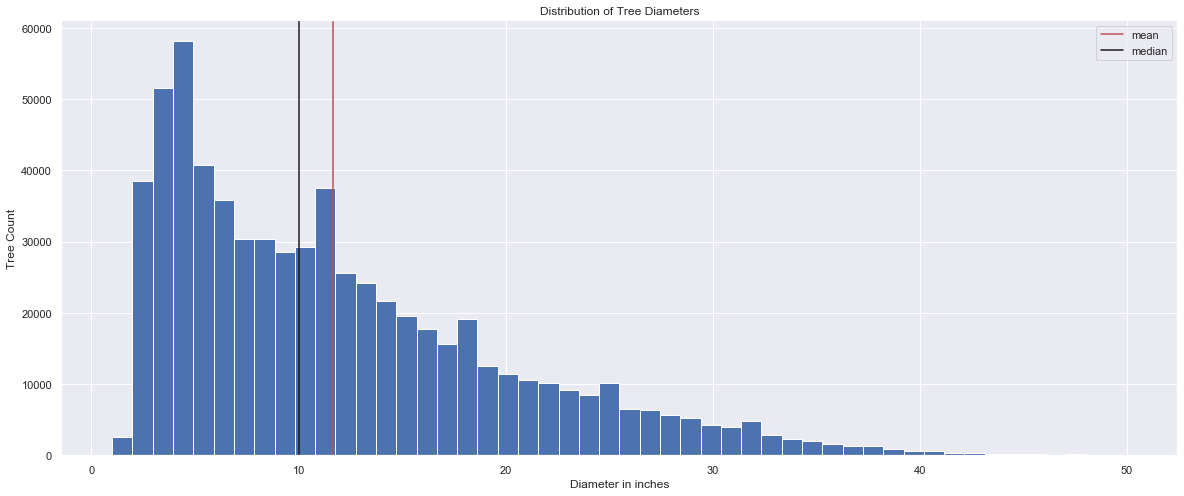

In [36]:
plt.figure(figsize=(20, 8))
tree.tree_dbh.hist(bins=50)
plt.xlabel('Diameter in inches')
plt.ylabel('Tree Count')
plt.title('Distribution of Tree Diameters')
plt.axvline(np.mean(tree.tree_dbh), color='r', label='mean')
plt.axvline(np.median(tree.tree_dbh), color='k', label='median')
plt.legend()
plt.show()

In [37]:
# printing the mean and median
rp.summary_cont(tree.tree_dbh)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,tree_dbh,651535.0,11.674665,8.366295,0.010365,11.65435,11.69498


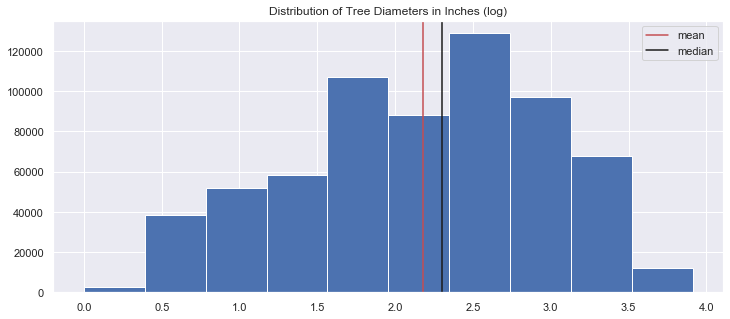

In [38]:
# take the log of tree_dbh
dbh_log = np.log(tree.tree_dbh)

plt.figure(figsize=(12, 5))
dbh_log.hist()
plt.title('Distribution of Tree Diameters in Inches (log)')
plt.axvline(np.mean(dbh_log), color='r', label='mean')
plt.axvline(np.median(dbh_log), color='k', label='median')
plt.legend()
plt.show() # the distribution appears closer to normal after taking the log

Taking the log of the diameters, the distribution is slightly skewed to the left but is closer to a normal distribution than previously.

In [39]:
rp.summary_cont(tree.groupby('health')['tree_dbh'])

,N,Mean,SD,SE,95% Conf.,Interval
health,,,,,,
Fair,96427,10.954370,7.61766,0.024531,10.906288,11.002451
Good,528327,11.942466,8.53741,0.011746,11.919444,11.965487
Poor,26781,8.985064,6.74574,0.041221,8.904270,9.065858


In [40]:
# group diameters according to tree health
health_good = tree[tree.health == 'Good']['tree_dbh']
health_fair = tree[tree.health =='Fair']['tree_dbh']
health_poor = tree[tree.health == 'Poor']['tree_dbh']

# bootstrap functions to draw samples from
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for x in range(size)])

In [41]:
# comparing good and fair trees
mean_good = np.mean(health_good)
mean_fair = np.mean(health_fair)
mean_poor = np.mean(health_poor)

# draw bootstrap reps
bs_reps_good = draw_bs_reps(health_good, np.mean, size=10000)
bs_reps_fair = draw_bs_reps(health_fair, np.mean, size=10000)
bs_reps_poor = draw_bs_reps(health_poor, np.mean, size=10000)

# Compute 95% confidence intervals
conf_int_good = np.percentile(bs_reps_good, [2.5, 97.5])
conf_int_fair = np.percentile(bs_reps_fair, [2.5, 97.5])
conf_int_poor = np.percentile(bs_reps_poor, [2.5, 97.5])

# Print the results
print("""
good:  mean = {0:.4f} min., conf. int. = [{1:.4f}, {2:.4f}] min.
fair: mean = {3:.4f} min., conf. int. = [{4:.4f}, {5:.4f}] min.
poor: mean = {6:.4f} min., conf. int. = [{7:.4f}, {8:.4f}] min.
""".format(mean_good, *conf_int_good, mean_fair, *conf_int_fair, mean_poor, *conf_int_poor))


good:  mean = 11.9425 min., conf. int. = [11.9194, 11.9659] min.
fair: mean = 10.9544 min., conf. int. = [10.9050, 11.0021] min.
poor: mean = 8.9851 min., conf. int. = [8.9037, 9.0663] min.



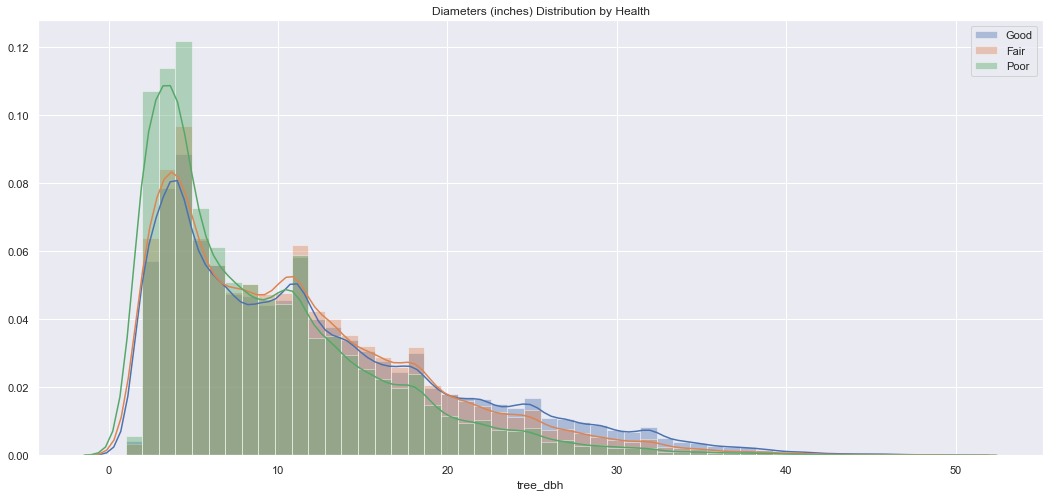

In [42]:
# plotting the distribution of diameters
plt.figure(figsize=(18, 8))
sns.distplot(health_good, label='Good')
sns.distplot(health_fair, label='Fair')
sns.distplot(health_poor, label='Poor')
plt.title('Diameters (inches) Distribution by Health')
plt.legend()
plt.show()

Since we are comparing three groups of trees (Good, Fair, Poor), we will use the analysis of variance, or ANOVA, test as an extension to the t-test.

While conducting this test, we will sample from our groups so that each group has the same size by randomly sampling 10,000 data points for each set.

In [43]:
anova_bs_reps_good = draw_bs_reps(health_good, np.mean, size=10000)
anova_bs_reps_fair = draw_bs_reps(health_fair, np.mean, size=10000)
anova_bs_reps_poor = draw_bs_reps(health_poor, np.mean, size=10000)

In [44]:
# multiple hypothesis testing
stats.f_oneway(anova_bs_reps_good, anova_bs_reps_fair, anova_bs_reps_poor)

F_onewayResult(statistic=28282206.604538202, pvalue=0.0)

The [f-statistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) is large and our p-value is small, which means that there is statistical significance between these groups.

In [45]:
diam_health = ols('tree_dbh ~ health', data=tree).fit()
dh_table = sm.stats.anova_lm(diam_health, typ=2)

display(dh_table)

,sum_sq,df,F,PR(>F)
health,2.816514e+05,2.0,2024.43944,0.0
Residual,4.532240e+07,651532.0,NaN,NaN


## Analyzing Problems Distribution

We use a 2-sample t-test in order to determine any significance between two population means.

In [46]:
rp.summary_cont(tree.groupby('health')['num_problems'])

,N,Mean,SD,SE,95% Conf.,Interval
health,,,,,,
Fair,96427,0.643658,0.872558,0.002810,0.638150,0.649165
Good,528327,0.430014,0.710553,0.000978,0.428098,0.431930
Poor,26781,0.684328,0.980530,0.005992,0.672585,0.696072


In [47]:
pd.crosstab(tree.health, [tree.num_problems])

num_problems,0,1,2,3,4,5,6,7,8,9
health,,,,,,,,,,
Fair,53915,27984,10436,3275,717,84,15,1,0,0
Good,356491,127845,34377,8011,1479,105,18,1,0,0
Poor,15486,6579,2901,1414,324,59,16,0,1,1


In [48]:
# group according to tree health
probs_good = tree[tree.health == 'Good']['num_problems']
probs_fair = tree[tree.health =='Fair']['num_problems']
probs_poor = tree[tree.health == 'Poor']['num_problems']

In [49]:
# find the mean of each group
mean_probs_good = np.mean(probs_good)
mean_probs_fair = np.mean(probs_fair)
mean_probs_poor = np.mean(probs_poor)

# draw bootstrap reps
bs_reps_probs_good = draw_bs_reps(probs_good, np.mean, size=10000)
bs_reps_probs_fair = draw_bs_reps(probs_fair, np.mean, size=10000)
bs_reps_probs_poor = draw_bs_reps(probs_poor, np.mean, size=10000)

# Compute 95% confidence intervals
conf_int_probs_good = np.percentile(bs_reps_probs_good, [2.5, 97.5])
conf_int_probs_fair = np.percentile(bs_reps_probs_fair, [2.5, 97.5])
conf_int_probs_poor = np.percentile(bs_reps_probs_poor, [2.5, 97.5])

# Print the results
print("""
good:  mean = {0:.4f} min., conf. int. = [{1:.4f}, {2:.4f}] min.
fair: mean = {3:.4f} min., conf. int. = [{4:.4f}, {5:.4f}] min.
poor: mean = {6:.4f} min., conf. int. = [{7:.4f}, {8:.4f}] min.
""".format(mean_probs_good, *conf_int_probs_good, mean_probs_fair, *conf_int_probs_fair, mean_probs_poor, *conf_int_probs_poor))


good:  mean = 0.4300 min., conf. int. = [0.4281, 0.4319] min.
fair: mean = 0.6437 min., conf. int. = [0.6381, 0.6492] min.
poor: mean = 0.6843 min., conf. int. = [0.6725, 0.6960] min.



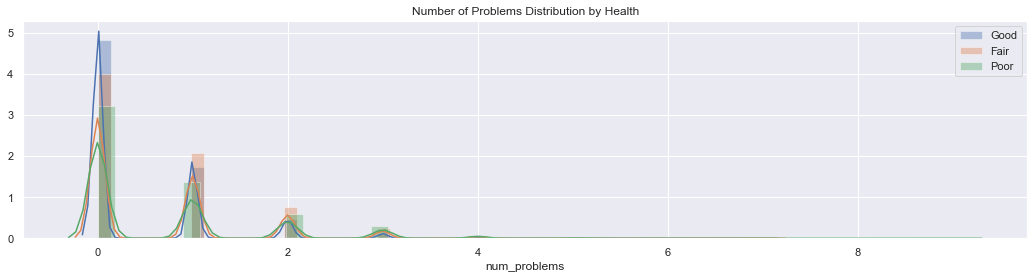

In [50]:
# plotting problems distribution

plt.figure(figsize=(18, 4))
sns.distplot(probs_good, label='Good')
sns.distplot(probs_fair, label='Fair')
sns.distplot(probs_poor, label='Poor')
plt.title('Number of Problems Distribution by Health')
plt.legend()
plt.show()

In [51]:
anova_bs_reps_probs_good = draw_bs_reps(probs_good, np.mean, size=10000)
anova_bs_reps_probs_fair = draw_bs_reps(probs_fair, np.mean, size=10000)
anova_bs_reps_probs_poor = draw_bs_reps(probs_poor, np.mean, size=10000)

In [52]:
# multiple hypothesis testing
stats.f_oneway(anova_bs_reps_probs_good, anova_bs_reps_probs_fair, anova_bs_reps_probs_poor)

F_onewayResult(statistic=12364565.071612371, pvalue=0.0)

While the number of problems a tree has decreases as the problems increases, after 7 problems, two poor trees have 8 or 9 problems. Overall, there are far less poor trees than good or fair trees.

In [53]:
probs_health = ols('num_problems ~ health', data=tree).fit()
ph_table = sm.stats.anova_lm(probs_health, typ=2)

display(ph_table)

,sum_sq,df,F,PR(>F)
health,4980.080714,2.0,4433.764049,0.0
Residual,365906.023830,651532.0,NaN,NaN


# Correlation Between Variables

The machine learning models assume that all variables are independent of one another. In order to test for correlations between variables, we must use a heatmap to show the degree of correlation between all (supposedly independent) variables. If the correlation between two variables is greater than 0.7 or less than -0.7, we must drop one of the columns.

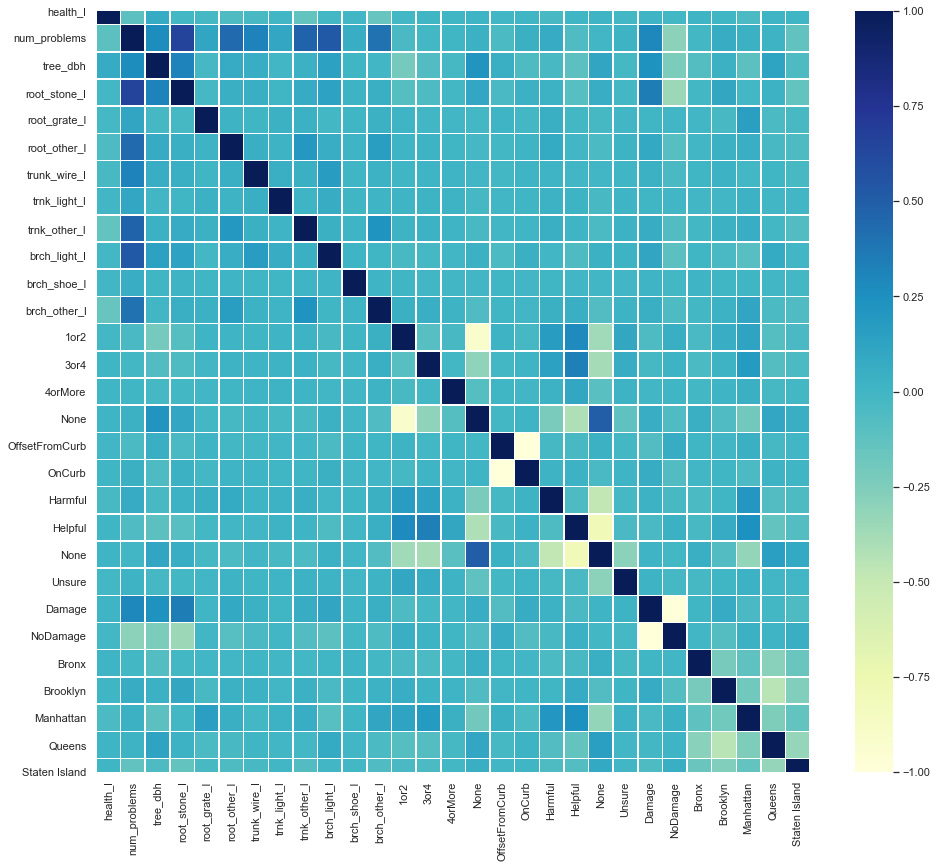

In [54]:
tree_corr = tree_encode.drop(columns='health')

plt.figure(figsize=(16,14))
sns.heatmap(tree_corr.corr(), center=0, cmap='YlGnBu', linewidths=.5)
plt.show()

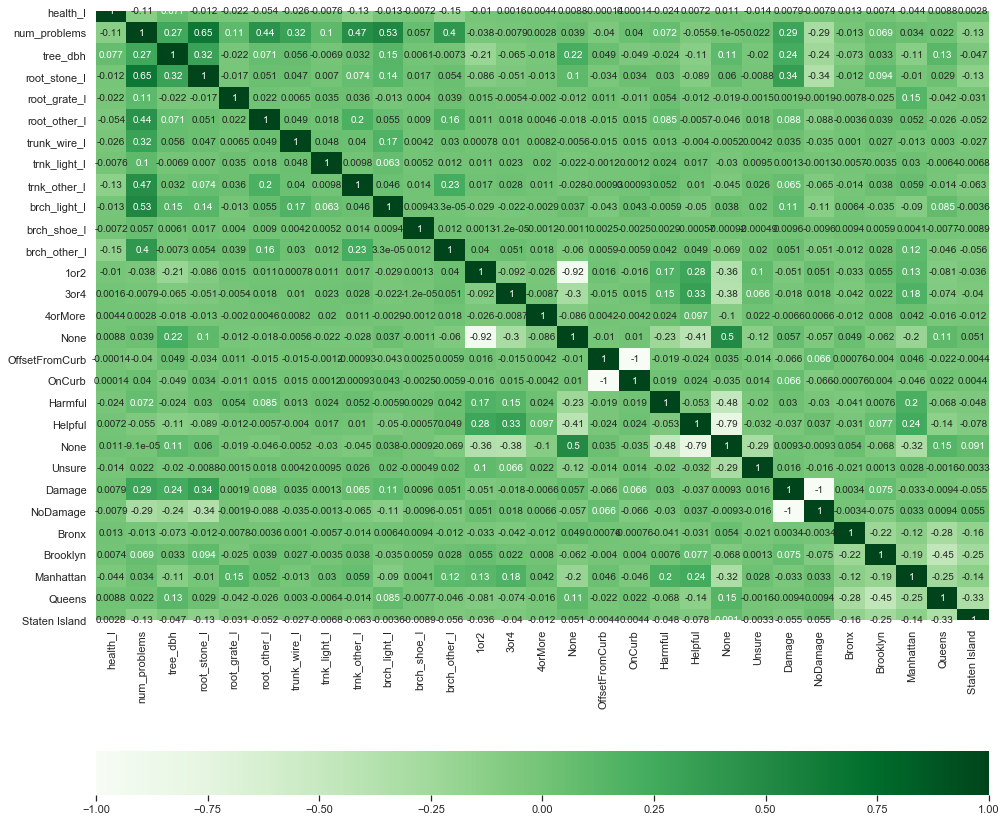

In [55]:
# as long as correlation is less than 0.7 or more than -0.7, we can keep the columns
plt.figure(figsize=(16, 16))
sns.heatmap(tree_corr.corr(), center=0, cmap='Greens', annot=True, cbar_kws={'orientation': 'horizontal'})
plt.show()

There are two columns with direct correlations to each other, OnCurb and OffsetFromCurb. The same thing with Damage and NoDamage. Looking at where these columns came from, curb_loc and sidewalk respectively, they are similar to binary columns. We remove the OffsetFromCurb and NoDamage columns.

# Removing and Relabeling Columns

In [56]:
# dropping four columns from tree_corr

tree_corr = tree_corr.drop(columns=['OffsetFromCurb','NoDamage'])

In [57]:
tree_corr.columns

Index(['health_l', 'num_problems', 'tree_dbh', 'root_stone_l', 'root_grate_l',
       'root_other_l', 'trunk_wire_l', 'trnk_light_l', 'trnk_other_l',
       'brch_light_l', 'brch_shoe_l', 'brch_other_l', '1or2', '3or4',
       '4orMore', 'None', 'OnCurb', 'Harmful', 'Helpful', 'None', 'Unsure',
       'Damage', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype='object')

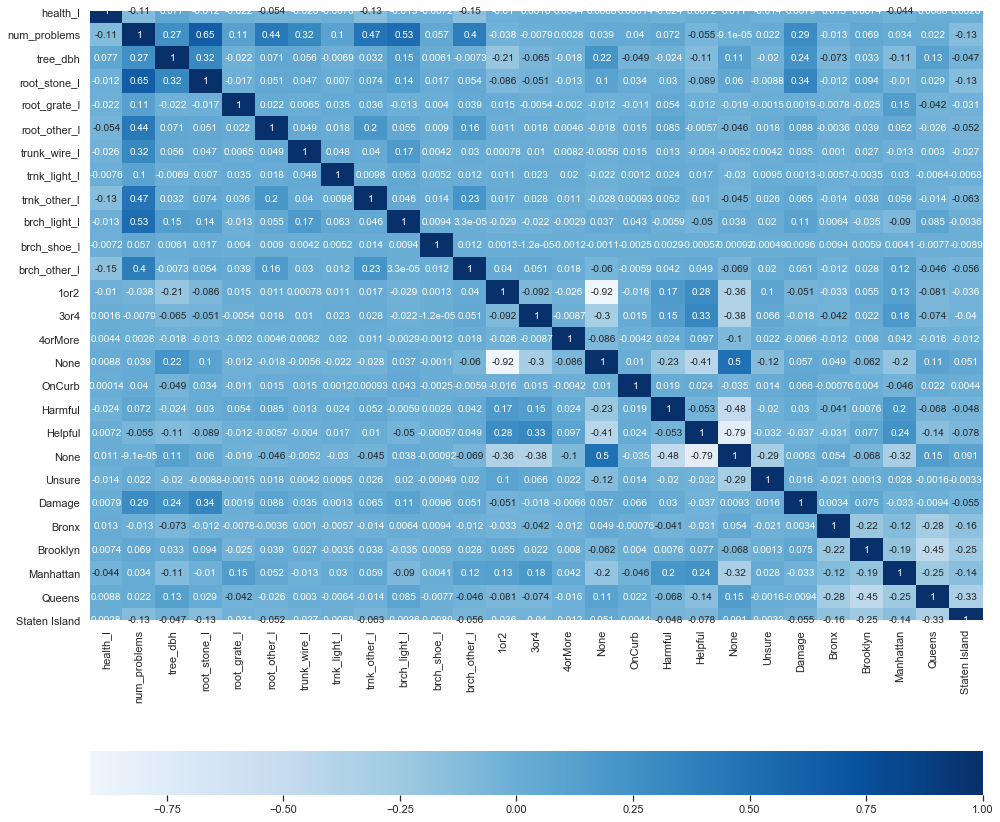

In [58]:
# look for correlations between variables

plt.figure(figsize=(16, 16))
sns.heatmap(tree_corr.corr(), center=0, cmap='Blues', annot=True, cbar_kws={'orientation': 'horizontal'})
plt.show()

There are two more sets of columns that have strong inverse correlations to each other: None and 1or2 and None and Helpful. We remove both of the None columns.

In [59]:
tree_corr = tree_corr.drop(columns=['None', 'None'])

In [60]:
tree_corr.columns

Index(['health_l', 'num_problems', 'tree_dbh', 'root_stone_l', 'root_grate_l',
       'root_other_l', 'trunk_wire_l', 'trnk_light_l', 'trnk_other_l',
       'brch_light_l', 'brch_shoe_l', 'brch_other_l', '1or2', '3or4',
       '4orMore', 'OnCurb', 'Harmful', 'Helpful', 'Unsure', 'Damage', 'Bronx',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype='object')

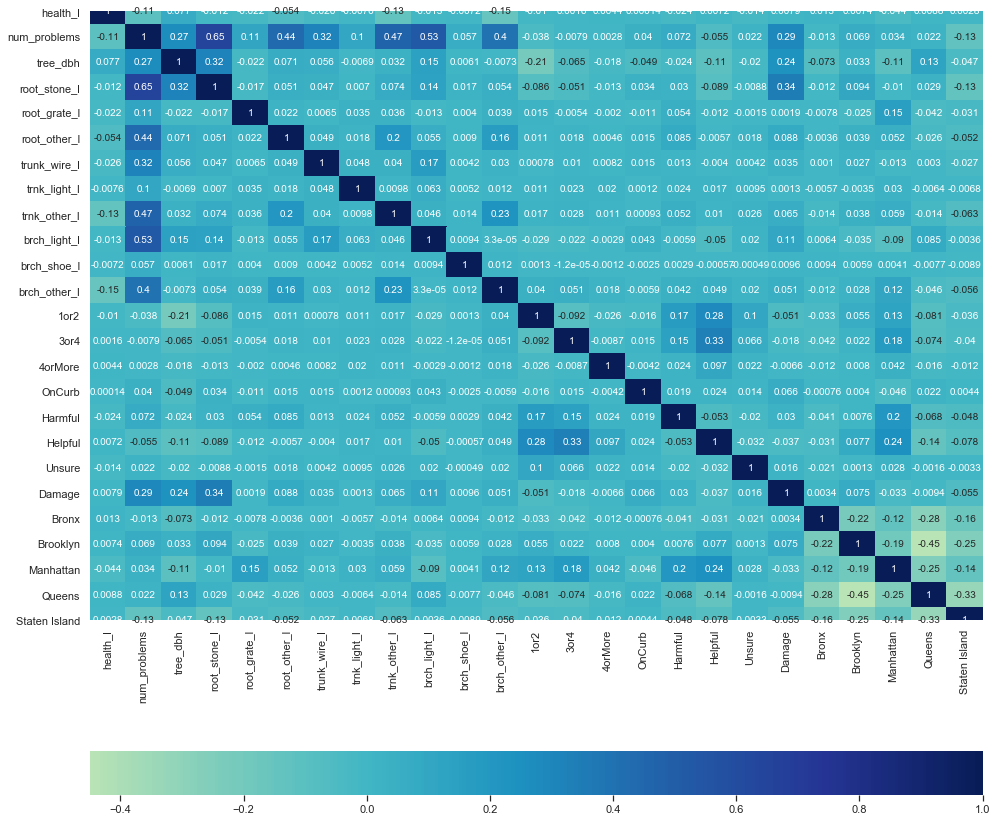

In [61]:
# final check for correlation
plt.figure(figsize=(16, 16))
sns.heatmap(tree_corr.corr(), center=0, cmap='YlGnBu', annot=True, cbar_kws={'orientation': 'horizontal'})
plt.show()

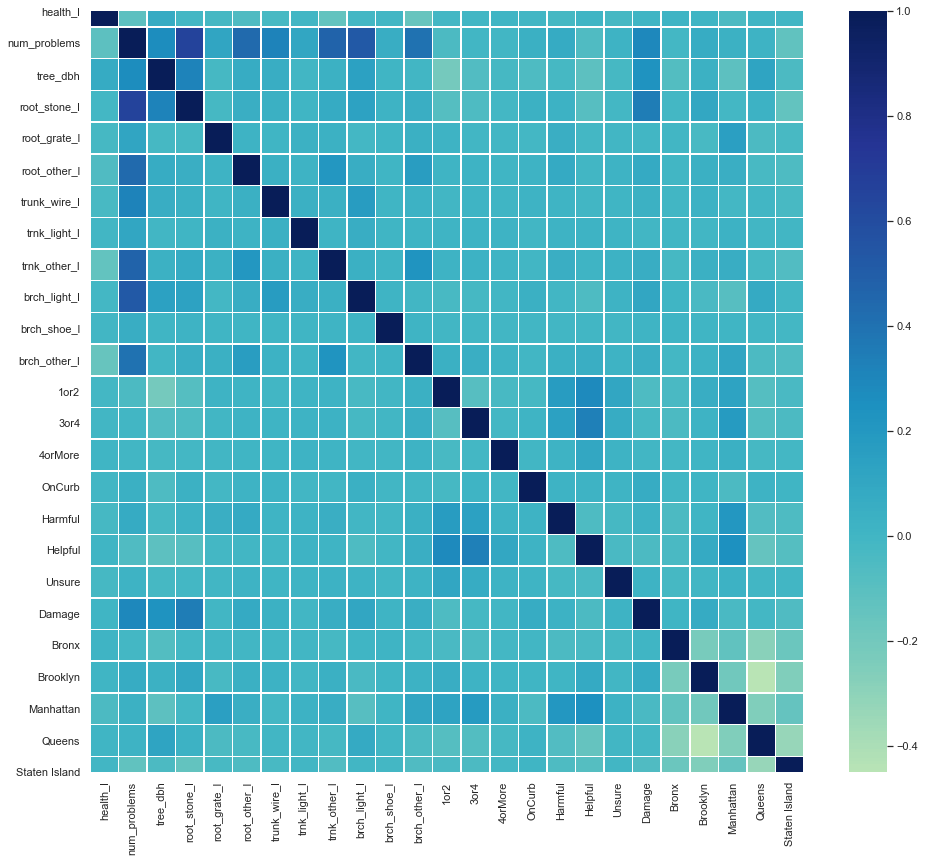

In [67]:
# final check for correlation - without numbers
plt.figure(figsize=(16, 14))
sns.heatmap(tree_corr.corr(), center=0, cmap='YlGnBu', linewidths=.5)
plt.show()

There are no more columns with strong correlations between each other. We make the changes to tree_encode, which is used in the machine learning step.

In [63]:
tree_encode = tree_encode.drop(columns=['OffsetFromCurb','NoDamage', 'None', 'None'])

In [64]:
tree_encode.columns

Index(['health', 'health_l', 'num_problems', 'tree_dbh', 'root_stone_l',
       'root_grate_l', 'root_other_l', 'trunk_wire_l', 'trnk_light_l',
       'trnk_other_l', 'brch_light_l', 'brch_shoe_l', 'brch_other_l', '1or2',
       '3or4', '4orMore', 'OnCurb', 'Harmful', 'Helpful', 'Unsure', 'Damage',
       'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype='object')

# Next Steps

In [65]:
# save encoded data to a new file for machine learning
# tree_encode.to_csv('tree_ml.csv')